# EdgeConv

```
@misc{wang2018dynamic,
  added-at = {2018-02-10T13:42:21.000+0100},
  author = {Wang, Yue and Sun, Yongbin and Liu, Ziwei and Sarma, Sanjay E. and Bronstein, Michael M. and Solomon, Justin M.},
  biburl = {https://www.bibsonomy.org/bibtex/2583c051f50803a30a60cb50532fc9619/jk_itwm},
  description = {1801.07829.pdf},
  interhash = {ff46d0c7d6e76b2bb7c42139db38cf75},
  intrahash = {583c051f50803a30a60cb50532fc9619},
  keywords = {CNN graph point_cloud},
  note = {cite arxiv:1801.07829},
  timestamp = {2018-02-10T13:42:21.000+0100},
  title = {Dynamic Graph CNN for Learning on Point Clouds},
  url = {http://arxiv.org/abs/1801.07829},
  year = 2018
}

```

In [1]:
import dgl
from dgl.data import DGLDataset
import torch
import os
import pandas as pd
import numpy as np
import torch
import itertools
import numpy as np
import scipy.sparse as sp
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from dgl.nn import EdgeConv
from utils.startup_data_set import *
from utils.PredictorClasses import *
from utils.CustomMetrics import *
from utils.CustomUtilities import *
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Dataset

In [2]:
graph = COMP4222Dataset()
g = graph[0].to(device)

## Generate Postitve Graph and Negative Graph with Spliting

In [3]:
train_g, train_pos_g, val_pos_g, test_pos_g, *_ = generate_pos_graph(g)

In [4]:
train_neg_g, val_neg_g, test_neg_g = generate_neg_graph(g)

In [5]:
train_g, train_pos_g, val_pos_g, test_pos_g = train_g.to(device), train_pos_g.to(device), val_pos_g, test_pos_g.to(device)
train_neg_g, val_neg_g, test_neg_g = train_neg_g.to(device), val_neg_g.to(device), test_neg_g.to(device)
num_nodes = g.num_nodes
num_edges = g.num_edges

## Model Training

### Model Setup

In [6]:
class DGCNN_Model(nn.Module):
    def __init__(self,
                 in_feat,
                 hidden_feat,
                 num_hiddern_layers,
                 out_feat):
        super(DGCNN_Model, self).__init__()

        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(EdgeConv(in_feat, hidden_feat))
        # hidden layers
        for i in range(num_hiddern_layers - 1):
            self.layers.append(EdgeConv(hidden_feat, hidden_feat))
        # output layer
        self.layers.append(EdgeConv(hidden_feat, out_feat))
        
    def forward(self, g, features):
        h = features.float()
        for layer in self.layers:
            h = layer(g, h).float()
        return h

In [7]:
dgcnn_model = DGCNN_Model(train_g.ndata["feat"].shape[1],32,2,16).to(device)
class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(2*h_feats , h_feats).to(torch.float32)
        self.W2 = nn.Linear(h_feats, 1).to(torch.float32)

    # concat the source and destination node, use mlp to predict the score
    def apply_edges(self, edges):
        h = torch.cat([edges.src['h'], edges.dst['h']], 1).to(torch.float32)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h.to(torch.float32)
            g.apply_edges(self.apply_edges)
            return g.edata['score']


pred = MLPPredictor(16).to(device)
early_stopping = 10


### Training Loop

In [8]:
import itertools

train_loss, val_loss = [], []
train_AUC, val_AUC = [], []
stop = 0
ep = 100
optimizer = torch.optim.Adam(itertools.chain(dgcnn_model.parameters(), pred.parameters()))

for e in range(ep):
    # forward
    h =  dgcnn_model(train_g, train_g.ndata['feat'].to(torch.float32))
    h = h.flatten(1)
    pos_score = pred(train_pos_g,h)
    neg_score = pred(train_neg_g,h)
    
    loss = compute_loss(pos_score, neg_score)
    train_loss.append(loss.item())
    train_AUC.append(compute_auc(pos_score, neg_score))

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # validation
    v_pos_score = pred(val_pos_g, h)
    v_neg_score = pred(val_neg_g, h)
    v_loss = compute_loss(v_pos_score, v_neg_score)
    val_loss.append(v_loss.item())
    val_AUC.append(compute_auc(v_pos_score, v_neg_score))

    #verbose
    if e % 10 == 0:
        print('Epoch: {} \t Train loss: {} \t Val loss: {} \t Train AUC: {} \t Val AUC: {}'.format(e, round(loss.item(), 3), round(v_loss.item(), 3), round(train_AUC[-1],3), round(val_AUC[-1], 3)))


    # early stopping
    if e > 10:
        if v_loss.item() > sum(val_loss[-5:])/5:
            stop += 1
        else: 
            stop = 0
        if stop >= early_stopping:
            print("Early Stopped at Epoch {}".format(e))
            break

Epoch: 0 	 Train loss: 0.695 	 Val loss: 0.694 	 Train AUC: 0.343 	 Val AUC: 0.416
Epoch: 10 	 Train loss: 0.682 	 Val loss: 0.682 	 Train AUC: 0.953 	 Val AUC: 0.927
Epoch: 20 	 Train loss: 0.65 	 Val loss: 0.652 	 Train AUC: 0.953 	 Val AUC: 0.935
Epoch: 30 	 Train loss: 0.579 	 Val loss: 0.585 	 Train AUC: 0.952 	 Val AUC: 0.936
Epoch: 40 	 Train loss: 0.477 	 Val loss: 0.494 	 Train AUC: 0.951 	 Val AUC: 0.935
Epoch: 50 	 Train loss: 0.386 	 Val loss: 0.42 	 Train AUC: 0.95 	 Val AUC: 0.935
Epoch: 60 	 Train loss: 0.303 	 Val loss: 0.358 	 Train AUC: 0.951 	 Val AUC: 0.936
Epoch: 70 	 Train loss: 0.275 	 Val loss: 0.379 	 Train AUC: 0.953 	 Val AUC: 0.937
Early Stopped at Epoch 72


In [9]:
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC:', compute_auc(pos_score, neg_score))

AUC: 0.937219738914053


### Result Plotting

Text(0, 0.5, 'Loss')

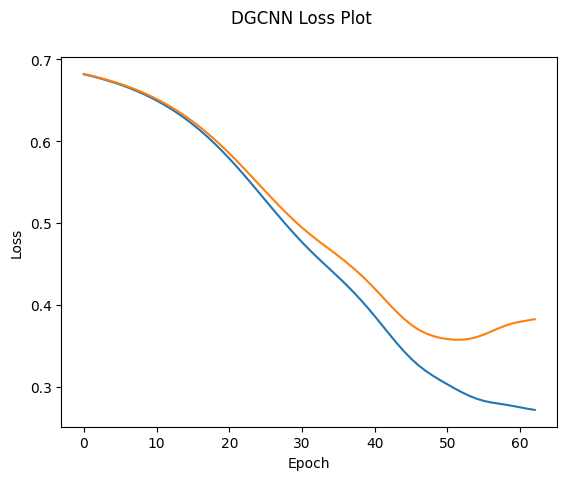

In [10]:
fig = plt.figure()
plt.plot(train_loss[10:], label='training loss')
plt.plot(val_loss[10:], label = 'validation loss')
fig.suptitle('DGCNN Loss Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'AUC')

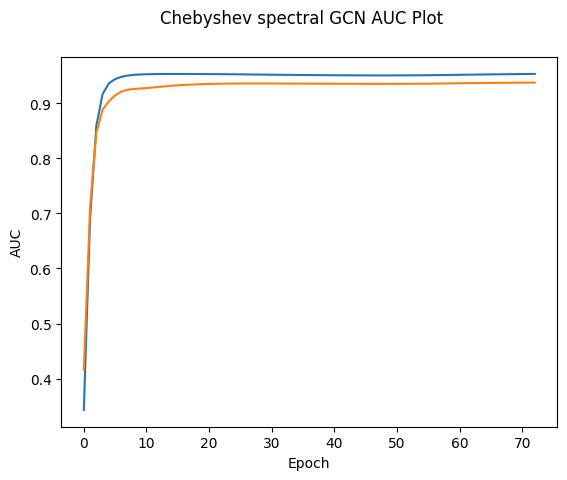

In [11]:
fig = plt.figure()
plt.plot(train_AUC, label='training AUC')
plt.plot(val_AUC, label = 'validation AUC')
fig.suptitle('Chebyshev spectral GCN AUC Plot')
plt.xlabel('Epoch')
plt.ylabel('AUC')